### Simple Linear Regression

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [3]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_prices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

#### EDA

Let's take a look at what comprises the data

In [4]:
house_prices_df.head()

id  mssubclass mszoning  lotfrontage  lotarea street alley lotshape  \
0   1          60       RL         65.0     8450   Pave  None      Reg   
1   2          20       RL         80.0     9600   Pave  None      Reg   
2   3          60       RL         68.0    11250   Pave  None      IR1   
3   4          70       RL         60.0     9550   Pave  None      IR1   
4   5          60       RL         84.0    14260   Pave  None      IR1   

  landcontour utilities  ... poolarea poolqc fence miscfeature miscval mosold  \
0         Lvl    AllPub  ...        0   None  None        None       0      2   
1         Lvl    AllPub  ...        0   None  None        None       0      5   
2         Lvl    AllPub  ...        0   None  None        None       0      9   
3         Lvl    AllPub  ...        0   None  None        None       0      2   
4         Lvl    AllPub  ...        0   None  None        None       0     12   

  yrsold  saletype  salecondition  saleprice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [6]:
#house_prices_df.info()

In [7]:
house_prices_df.describe()

id   mssubclass  lotfrontage        lotarea  overallqual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       overallcond    yearbuilt  yearremodadd   masvnrarea   bsmtfinsf1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ...   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000  ...   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000  ...   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000  ...   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000  ...   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000  ...   

        wooddecksf  openporchsf  enclosedporch  threessnporch  screenporch  \
count  1460.000000  1460.000000    1460.000000    1460.000000  1460.000000   
mean     94.244521    46.660274      21.954110       3.409589    15.060959   
std     125.338794    66.256028      61.119149      29.317331    55.757415   
min       0.000000     0.000000       0.000000       0.000000     0.000000   
25%       0.000000     0.000000       0.000000       0.000000     0.000000   
50%       0.000000    25.000000       0.000000       0.000000     0.000000   
75%     168.000000    68.000000       0.000000       0.000000     0.000000   
max     857.000000   547.000000     552.000000     508.000000   480.000000   

          poolarea       miscval       mosold       yrsold      saleprice  
count  1460.000000   1460.000000  1460.000000  1460.000000    1460.000000  
mean      2.758904     43.489041     6.321918  2007.815753  180921.195890  
std      40.177307    496.123024     2.703626     1.328095   79442.502883  
min       0.000000      0.000000     1.000000  2006.000000   34900.000000  
25%       0.000000      0.000000     5.000000  2007.000000  129975.000000  
50%       0.000000      0.000000     6.000000  2008.000000  163000.000000  
75%       0.000000      0.000000     8.000000  2009.000000  214000.000000  
max     738.000000  15500.000000    12.000000  2010.000000  755000.000000  

[8 rows x 38 columns]

So the data is comprised of a mix of numeric and non-numeric components. Let's figure out how many non-numeric v. numeric there are.

In [8]:
non_numeric_columns = house_prices_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


In [9]:
numeric_columns = house_prices_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


#### Checking for missing data

In [10]:
pd.DataFrame(house_prices_df.isnull().sum().sort_values(ascending=False)).head(10)

0
poolqc        1453
miscfeature   1406
alley         1369
fence         1179
fireplacequ    690
lotfrontage    259
garagecond      81
garagetype      81
garageyrblt     81
garagefinish    81

It looks like the first 6 make up 80-90% of the missing data. We might not need these examples in order to run our regression model. 

### Target Variable Distribution

As you can see below the distribution of housing prices are left skewed.

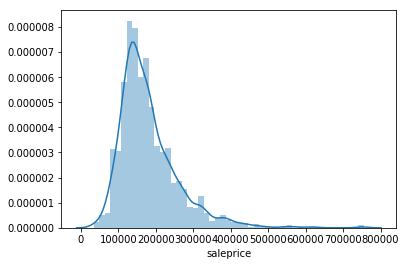

In [13]:
sns.distplot(house_prices_df.saleprice)
plt.show()

### Numeric feature correlation

In [19]:
numeric_df = house_prices_df.loc[:, [col for col in numeric_columns]]
non_numeric_df = house_prices_df.loc[:, [col for col in non_numeric_columns]]

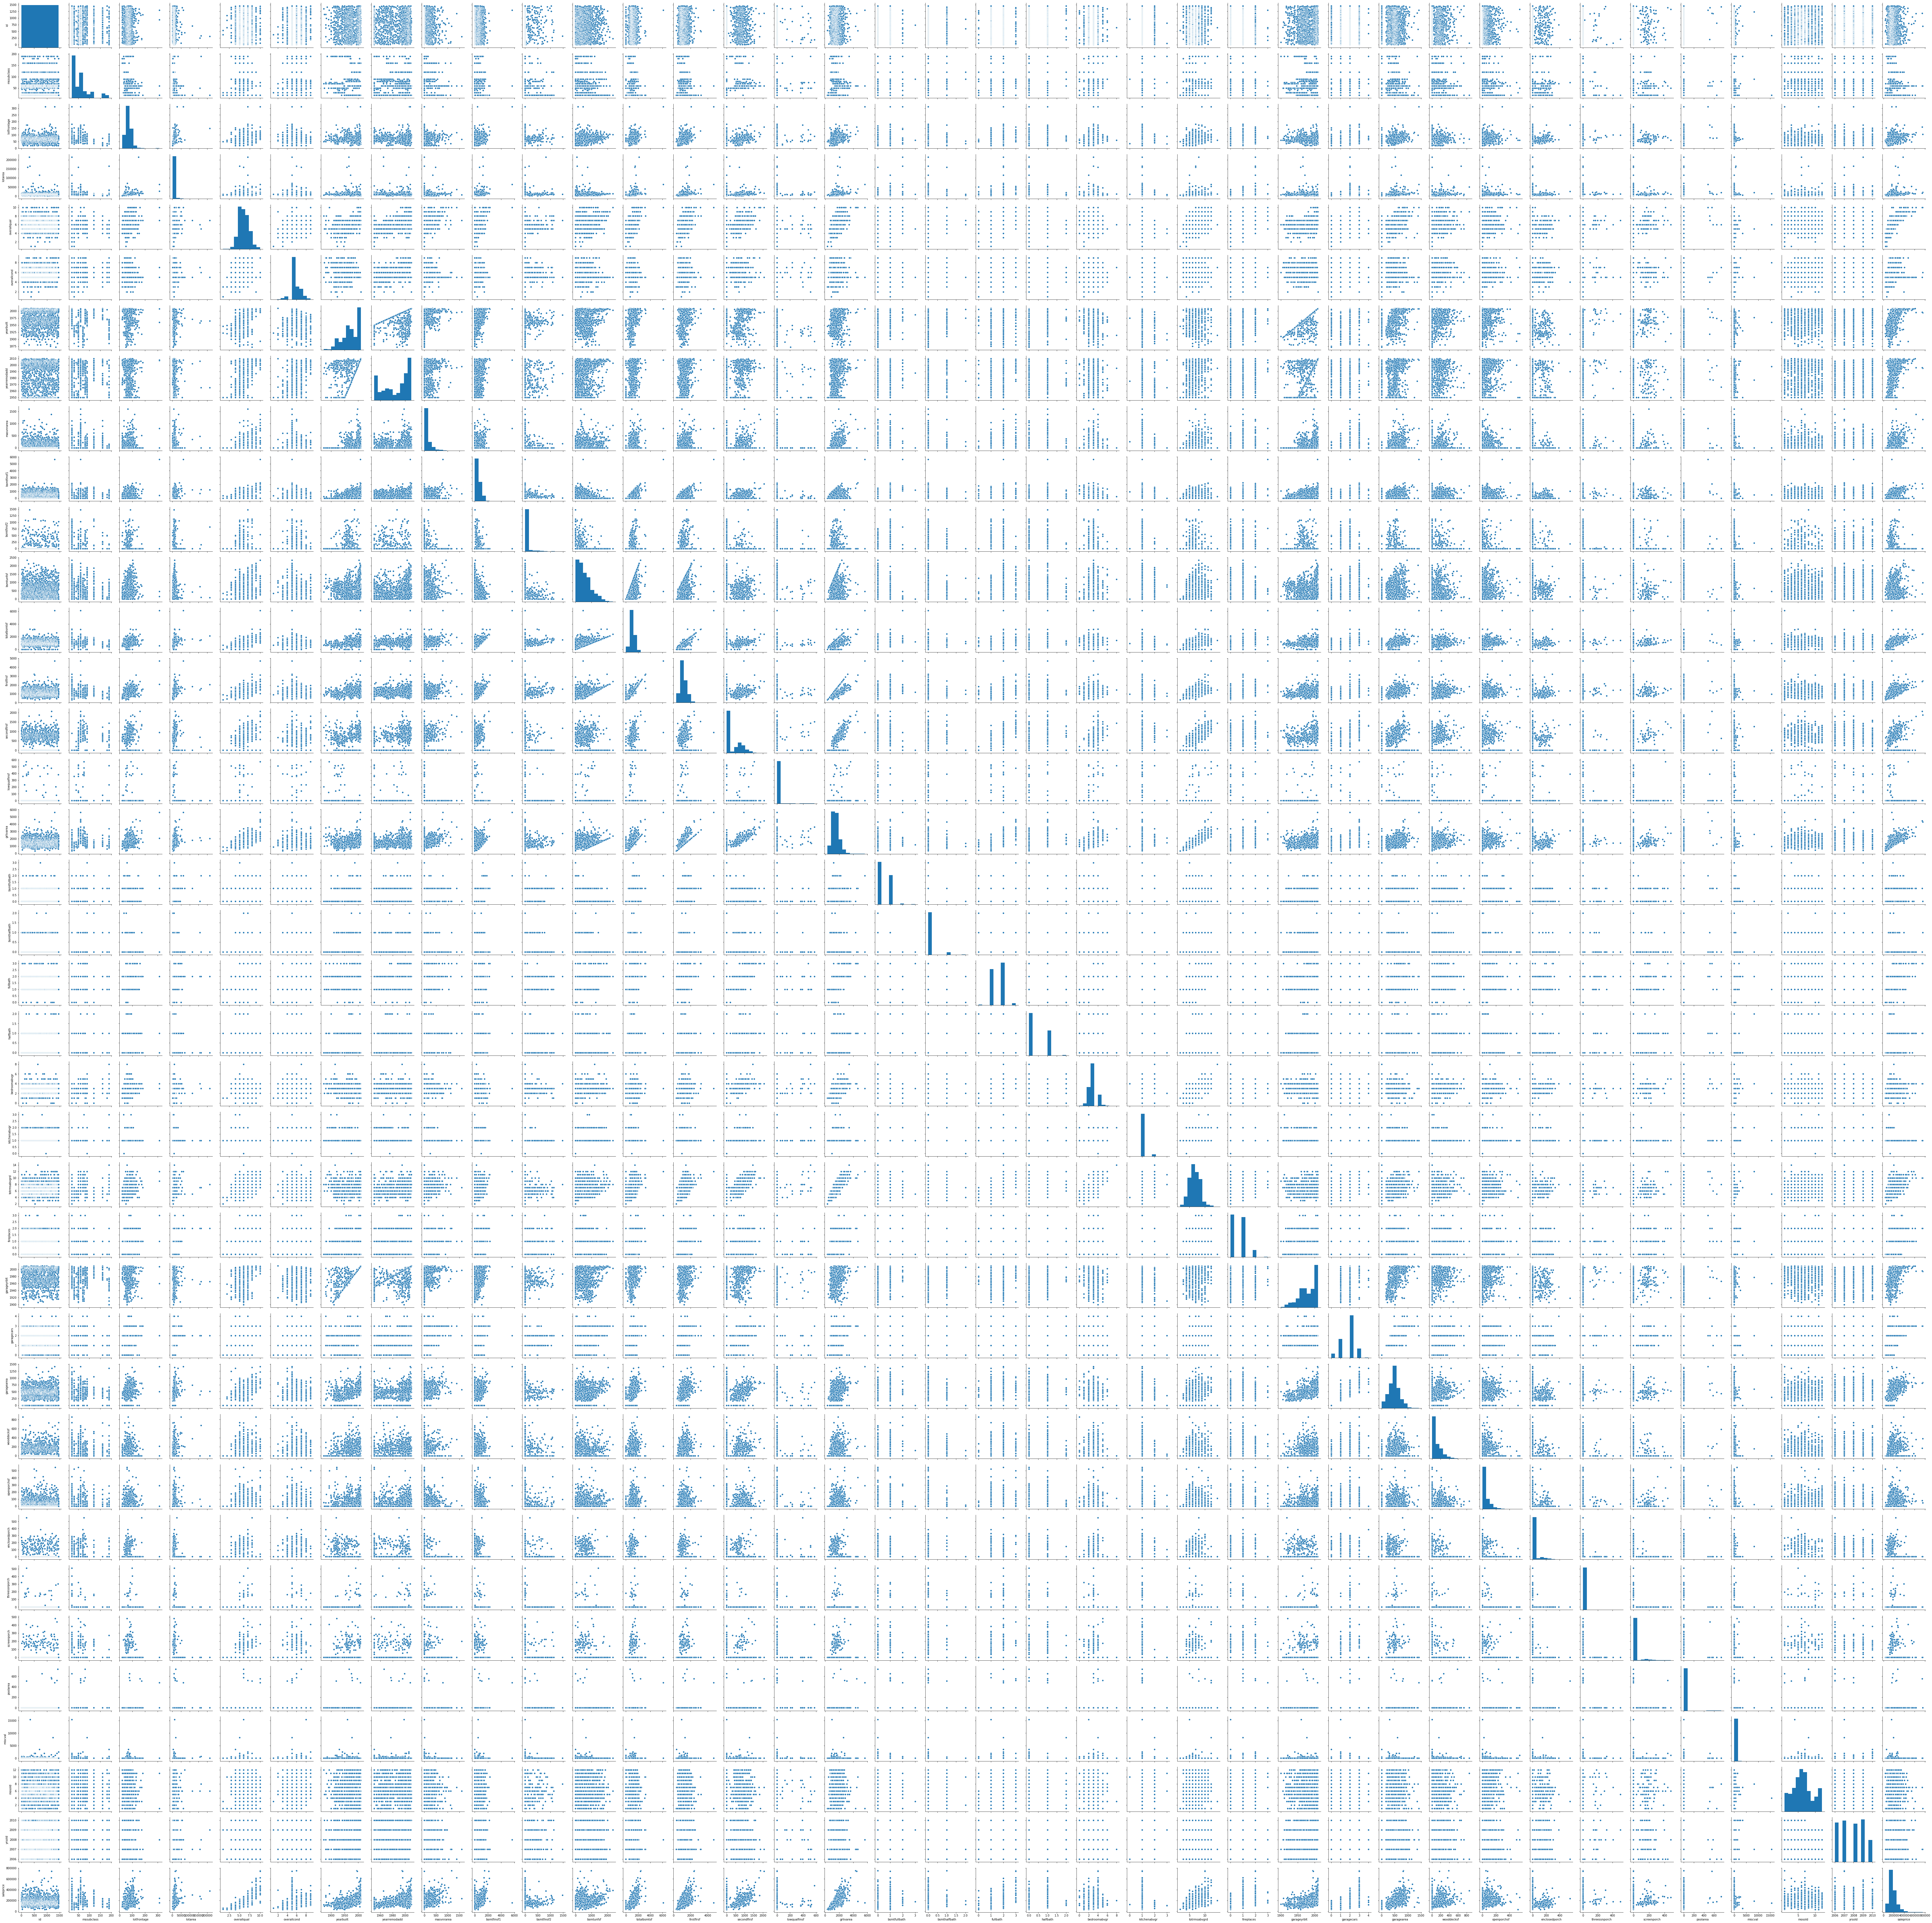

In [26]:
numeric_df = house_prices_df.loc[:, [col for col in numeric_columns]]

sns.pairplot(numeric_df)

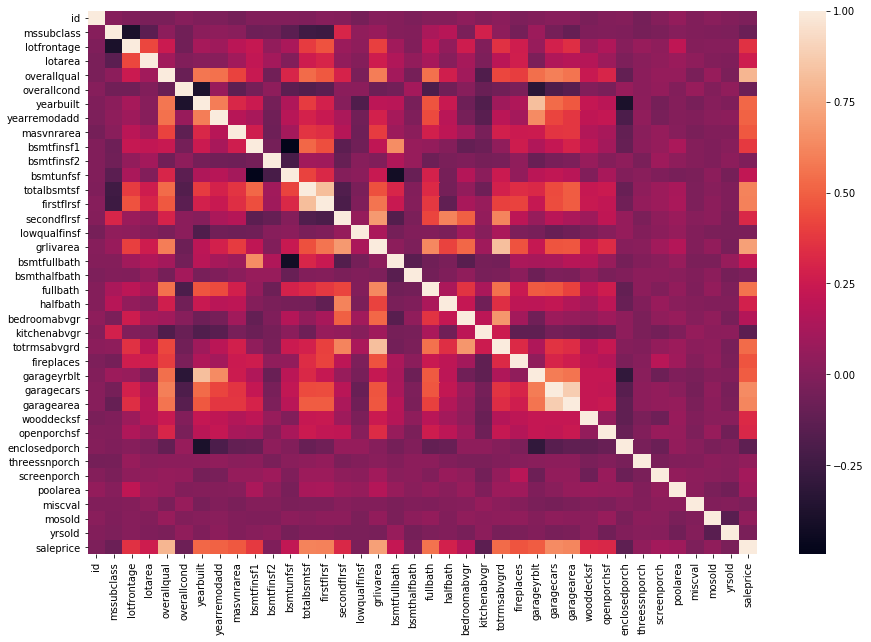

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
corr = numeric_df.corr()

sns.heatmap(corr)

plt.show()

#### List out top correlated features

In [17]:
top_corr = pd.DataFrame(np.abs(house_prices_df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]
                ).sort_values(
            ascending=False
        ))

top_corr.head(10)

saleprice
saleprice      1.000000
overallqual    0.790982
grlivarea      0.708624
garagecars     0.640409
garagearea     0.623431
totalbsmtsf    0.613581
firstflrsf     0.605852
fullbath       0.560664
totrmsabvgrd   0.533723
yearbuilt      0.522897

### Non-Numeric Features

In [20]:
for col in non_numeric_columns:
    print(non_numeric_df[col].unique())

['RL' 'RM' 'C (all)' 'FV' 'RH']
['Pave' 'Grvl']
[None 'Grvl' 'Pave']
['Reg' 'IR1' 'IR2' 'IR3']
['Lvl' 'Bnk' 'Low' 'HLS']
['AllPub' 'NoSeWa']
['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
['Gtl' 'Mod' 'Sev']
['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe']
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll'
 'ClyTile']
['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'CemntBd'
 'Plywood' 'AsbShng' 'Stucco' 'BrkComm' 'AsphShn' 'Stone' 'ImStucc'
 'CBlock']
['VinylSd' 'MetalSd' 'Wd Shn

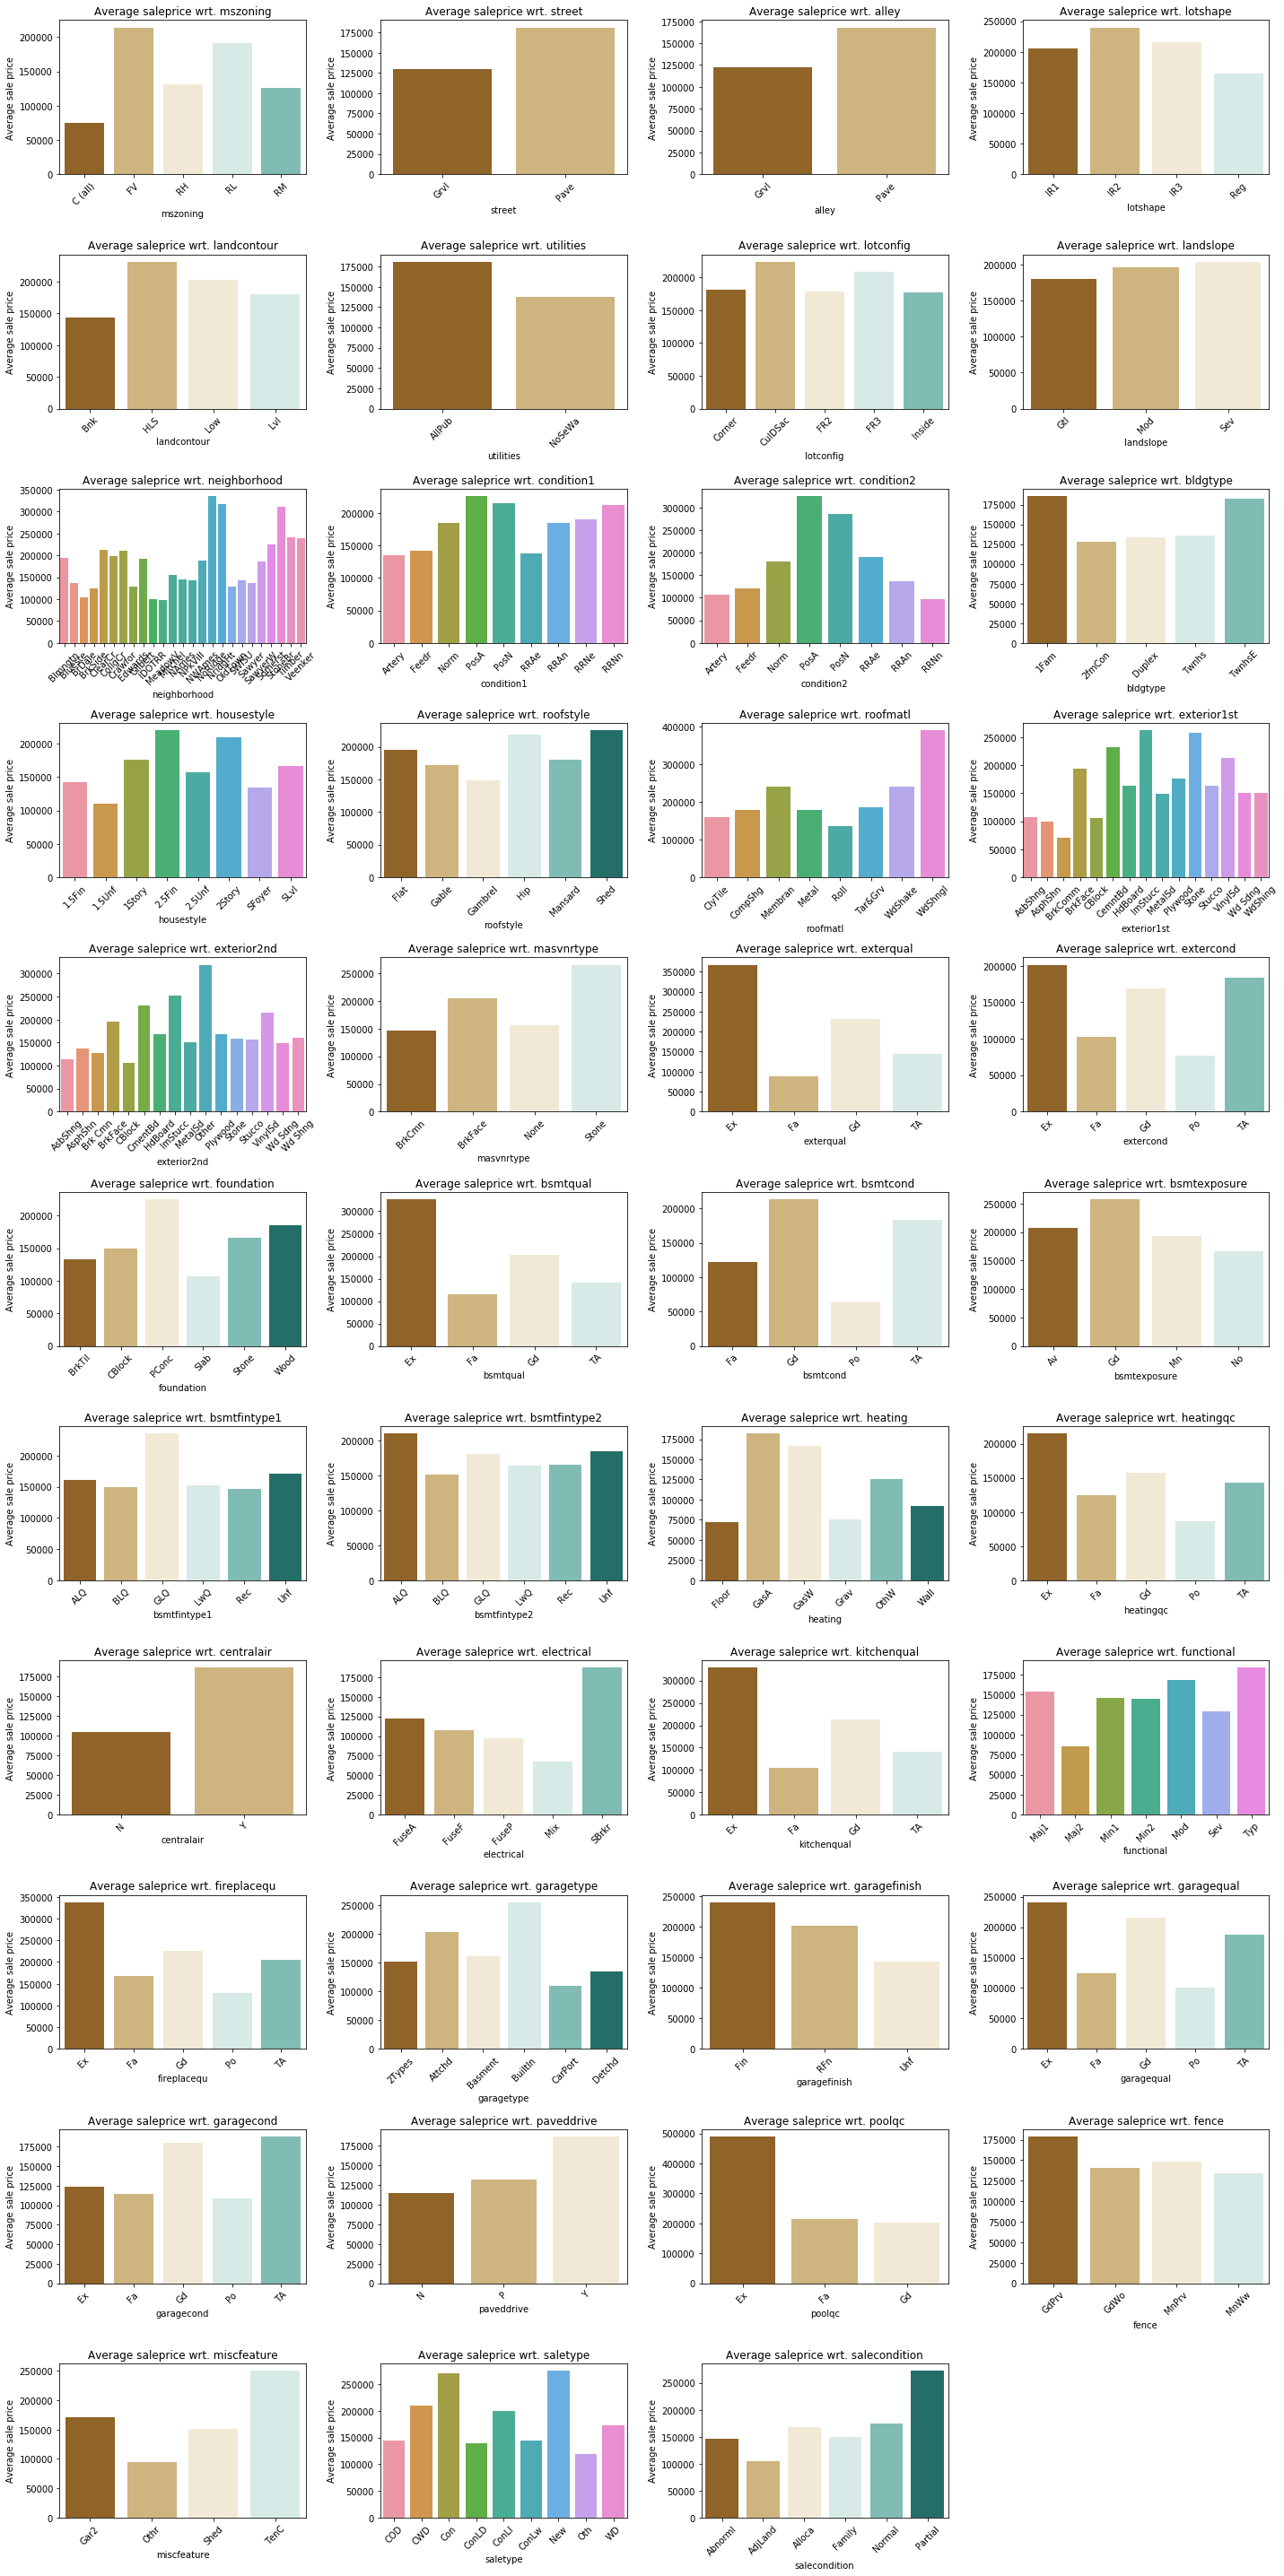

In [21]:
plt.figure(figsize = (20,40))
sns.set_palette('BrBG')

for i, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,i+1)
    sns.barplot(
            x=house_prices_df.groupby(column)['saleprice'].mean().index,
            y=house_prices_df.groupby(column)['saleprice'].mean()
    )
    
    plt.title("Average saleprice wrt. {}".format(column)),
    plt.ylabel("Average sale price")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

#### Regession Model - just numeric features

use the top 10 correlated features to see how the model fares...

In [88]:
top_numeric = top_corr.index.tolist()[1:10]

X = house_prices_df[top_numeric]
Y = house_prices_df.saleprice

In [91]:
X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     540.3
Date:                Thu, 12 Sep 2019   Prob (F-statistic):               0.00
Time:                        09:07:26   Log-Likelihood:                -17470.
No. Observations:                1460   AIC:                         3.496e+04
Df Residuals:                    1450   BIC:                         3.501e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.585e+05   9.15e+04     -8.294      0.000   -9.38e+05   -5.79e+05
overallqual   2.092e+04   1164.267     17.971      0.000    1.86e+04    2.32e+04
grlivarea       51.3679      4.263     12.051      0.000      43.006      59.730
garagecars    1.063e+04   3065.576      3.469      0.001    4620.797    1.66e+04
garagearea      14.5088     10.384      1.397      0.163      -5.861      34.879
totalbsmtsf     19.2466      4.324      4.451      0.000      10.765      27.728
firstflrsf      13.9481      4.965      2.810      0.005       4.210      23.687
fullbath     -5410.3114   2684.921     -2.015      0.044   -1.07e+04    -143.567
totrmsabvgrd   -86.6391   1126.726     -0.077      0.939   -2296.827    2123.549
yearbuilt      345.3629     47.886      7.212      0.000     251.430     439.295
==============================================================================
Omnibus:                      470.067   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            52956.991
Skew:                          -0.413   Prob(JB):                         0.00
Kurtosis:                      32.493   Cond. No.                     2.77e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.77e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Regession Model - numeric + some categorical

In [92]:
house_prices_df = pd.concat(
            [house_prices_df,pd.get_dummies(
                house_prices_df.mszoning, prefix="mszoning", drop_first=True)
        ], axis=1
)
house_prices_df = pd.concat(
            [house_prices_df,pd.get_dummies(
                house_prices_df.street, prefix="street", drop_first=True)
        ],  axis=1
    
)
dummy_column_names = list(
            pd.get_dummies(house_prices_df.mszoning, prefix="mszoning", drop_first=True
        ).columns
)

dummy_column_names = dummy_column_names + list(
        pd.get_dummies(house_prices_df.street, prefix="street", drop_first=True
).columns)

In [96]:
X = house_prices_df[top_numeric+dummy_column_names]
Y = house_prices_df.saleprice

In [97]:
X = sm.add_constant(X)
results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     353.1
Date:                Thu, 12 Sep 2019   Prob (F-statistic):               0.00
Time:                        09:11:51   Log-Likelihood:                -17459.
No. Observations:                1460   AIC:                         3.495e+04
Df Residuals:                    1445   BIC:                         3.503e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -6.306e+05   9.84e+04     -6.407      0.000   -8.24e+05   -4.38e+05
overallqual   2.139e+04   1173.631     18.225      0.000    1.91e+04    2.37e+04
grlivarea       52.2745      4.247     12.310      0.000      43.944      60.605
garagecars    1.086e+04   3068.060      3.538      0.000    4837.302    1.69e+04
garagearea      14.6955     10.429      1.409      0.159      -5.762      35.153
totalbsmtsf     19.8781      4.306      4.616      0.000      11.431      28.325
firstflrsf       9.8163      5.038      1.949      0.052      -0.066      19.699
fullbath     -4911.3506   2688.979     -1.826      0.068   -1.02e+04     363.370
totrmsabvgrd  -630.5114   1133.089     -0.556      0.578   -2853.187    1592.164
yearbuilt      271.4456     50.947      5.328      0.000     171.507     371.384
mszoning_FV   1.471e+04   1.38e+04      1.070      0.285   -1.23e+04    4.17e+04
mszoning_RH   8996.6949   1.57e+04      0.572      0.568   -2.19e+04    3.99e+04
mszoning_RL   2.048e+04   1.27e+04      1.612      0.107   -4435.259    4.54e+04
mszoning_RM   6683.4750   1.28e+04      0.523      0.601   -1.84e+04    3.18e+04
street_Pave   2089.5955   1.61e+04      0.129      0.897   -2.96e+04    3.38e+04
==============================================================================
Omnibus:                      448.364   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51907.314
Skew:                          -0.280   Prob(JB):                         0.00
Kurtosis:                      32.205   Cond. No.                     3.00e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  3e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""